In [21]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, ZeroPadding2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import LeakyReLU
from keras.layers import UpSampling2D, Conv2D
import matplotlib.pyplot as plt
import numpy as np
import keras
import tensorflow as tf
from keras import backend as K

In [22]:
img_row=28
img_cols=28
channels=1
LATENT_DIM = 100
BATCH_SIZE = 256
CLIP_VALUE = 0.01  # WGAN weight clipping
N_CRITIC = 2  # Train discriminator more often than generator
EPOCHS = 100

initial_learning_rate = 0.0002
decay_steps = 1000  # Number of steps before decay
decay_rate = 0.96  # Decay rate

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

gan_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.5)
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [23]:
(X_train, _), (_, _) = mnist.load_data()

# Normalize the images to [-1, 1]
X_train = X_train.astype('float32') / 127.5 - 1.0

# Reshape the dataset to include the channels dimension
X_train = np.expand_dims(X_train, axis=-1)

# Check the shape of the dataset
print(X_train.shape)

(60000, 28, 28, 1)


In [24]:
generator=Sequential([
        Dense(7 * 7 * 256, input_dim=LATENT_DIM),
        Reshape((7, 7, 256)),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(1, (4, 4), strides=(1, 1), padding='same', activation='tanh')  # Output shape (28, 28, 1)
    ])

generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12544)             1266944   
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 batch_normalization_3 (Bat  (None, 7, 7, 256)         1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 14, 14, 128)       524416    
 Transpose)                                                      
                                                                 
 batch_normalization_4 (Bat  (None, 14, 14, 128)      

In [25]:
discriminator=Sequential([
    keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', input_shape=(img_row, img_cols, channels)),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same'),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same'),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dropout(0.3),

    keras.layers.Flatten(),
    keras.layers.Dense(512,activation=LeakyReLU(alpha=0.2)),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(1)
])

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 256)        

In [26]:

from tensorflow.keras.optimizers import RMSprop
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

discriminator_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-5,  # Starting learning rate for the discriminator
    decay_steps=10000,            # Number of steps after which the learning rate decays
    decay_rate=0.9                # The factor by which the learning rate is multiplied
)

# Learning rate schedule for the generator
generator_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,   # Starting learning rate for the generator
    decay_steps=10000,            # Number of steps after which the learning rate decays
    decay_rate=0.9                # The factor by which the learning rate is multiplied
)

g_optimizer = tf.keras.optimizers.RMSprop(learning_rate=generator_lr_schedule)
d_optimizer = tf.keras.optimizers.RMSprop(learning_rate=discriminator_lr_schedule)


In [27]:
def display_generated_images(epoch, examples=20, dim=(2, 10), figsize=(10, 2)):
    noise = np.random.normal(0, 1, (examples, LATENT_DIM))
    generated_images = generator(noise)

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()  # Use show() to display the images instead of saving them

# Start training

Epoch: 0
Epoch: 0, D_loss: 0.12002372741699219, G_loss: -5.53085470199585


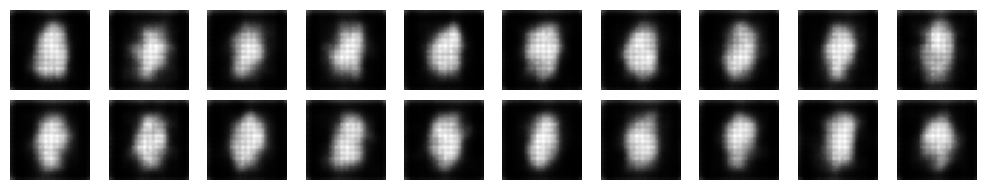

Epoch: 1
Epoch: 1, D_loss: -0.11162519454956055, G_loss: -3.0330522060394287


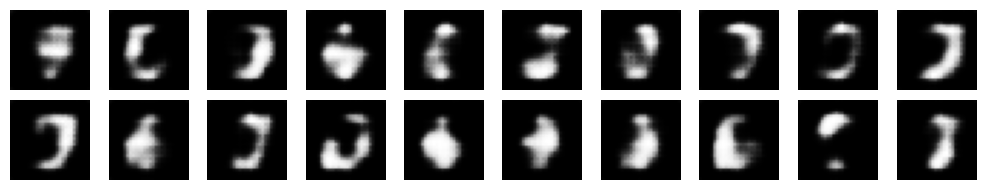

Epoch: 2
Epoch: 2, D_loss: -0.15114963054656982, G_loss: -0.7390685081481934


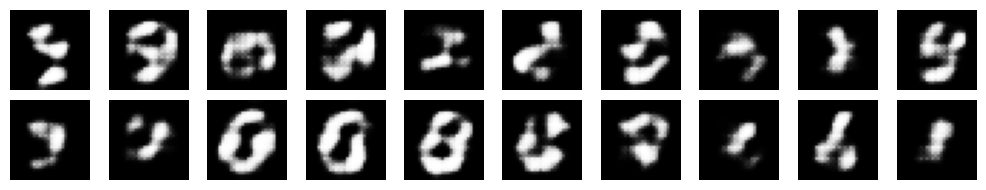

Epoch: 3
Epoch: 3, D_loss: -0.06697962433099747, G_loss: -0.1941705197095871


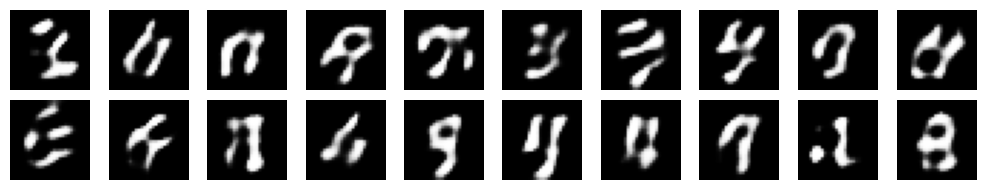

Epoch: 4
Epoch: 4, D_loss: -0.036787211894989014, G_loss: 0.042986612766981125


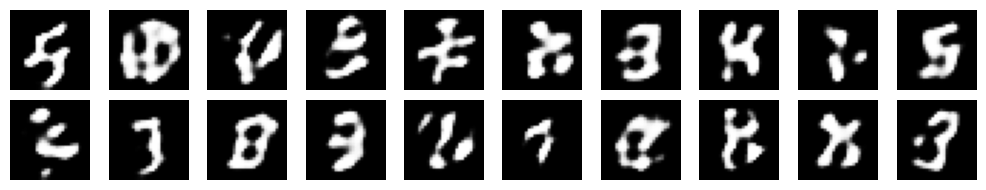

Epoch: 5
Epoch: 5, D_loss: -0.07043641805648804, G_loss: 0.014777272939682007


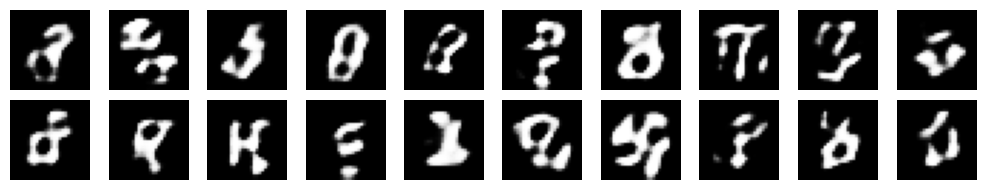

Epoch: 6
Epoch: 6, D_loss: -0.07924908399581909, G_loss: -0.3359275460243225


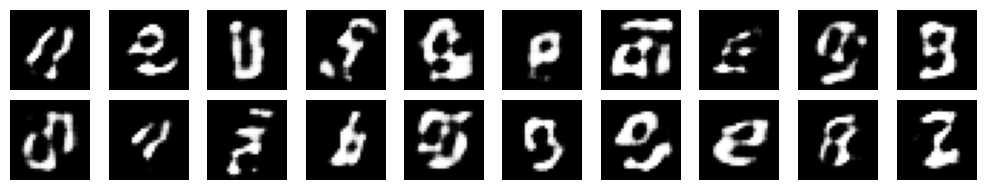

Epoch: 7
Epoch: 7, D_loss: -0.009108498692512512, G_loss: -0.027075789868831635


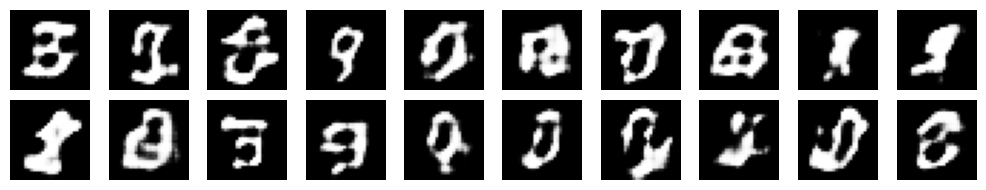

Epoch: 8
Epoch: 8, D_loss: -0.03912848234176636, G_loss: -0.30051374435424805


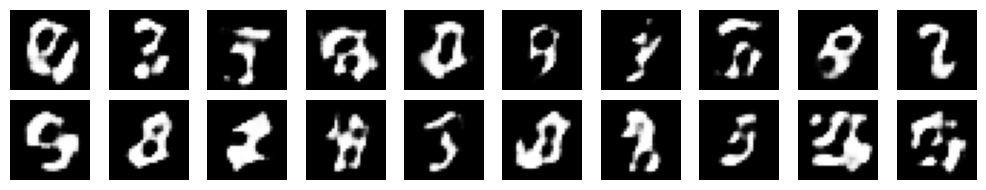

Epoch: 9
Epoch: 9, D_loss: -0.06153768301010132, G_loss: -0.5425097942352295


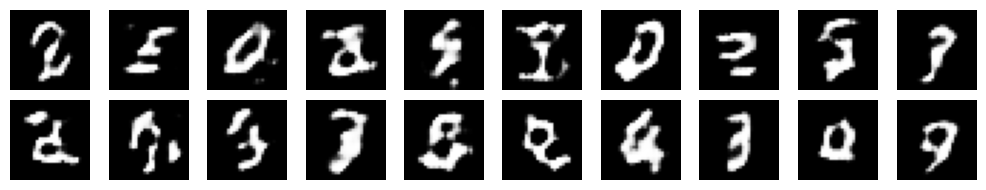

Epoch: 10
Epoch: 10, D_loss: 0.012461051344871521, G_loss: -0.0844021663069725


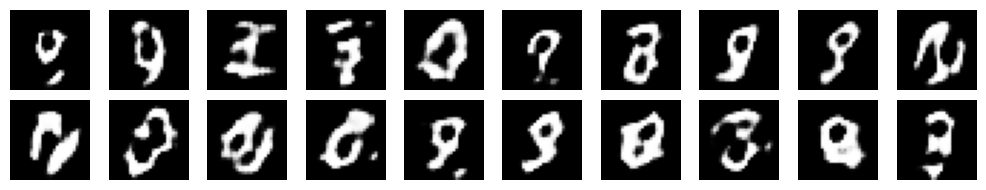

Epoch: 11
Epoch: 11, D_loss: -0.01806696318089962, G_loss: -0.28156232833862305


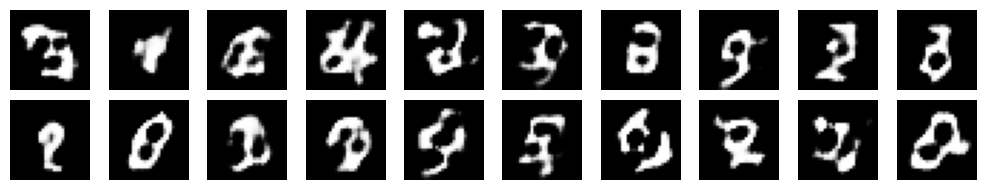

Epoch: 12
Epoch: 12, D_loss: 0.03984200954437256, G_loss: 0.27047014236450195


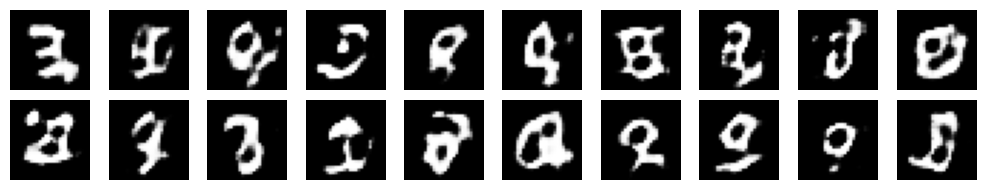

Epoch: 13
Epoch: 13, D_loss: 0.030811727046966553, G_loss: 0.2666320204734802


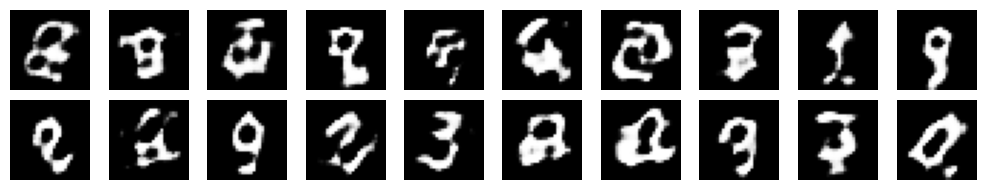

Epoch: 14
Epoch: 14, D_loss: 0.08605748414993286, G_loss: 0.2082509696483612


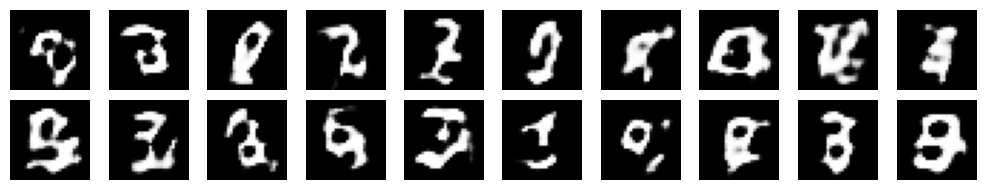

Epoch: 15
Epoch: 15, D_loss: 0.09122920036315918, G_loss: 0.8715510964393616


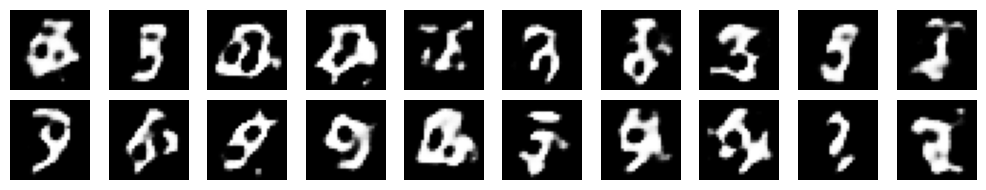

Epoch: 16
Epoch: 16, D_loss: -0.01999533176422119, G_loss: 0.8460396528244019


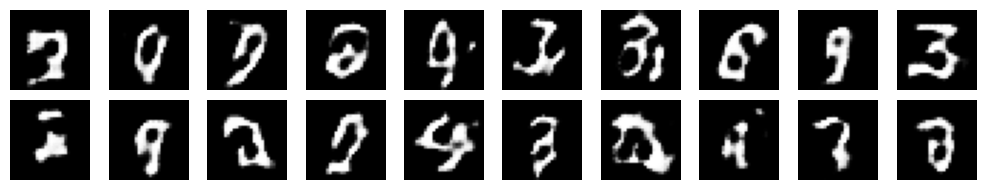

Epoch: 17
Epoch: 17, D_loss: 0.07938003540039062, G_loss: 0.535678505897522


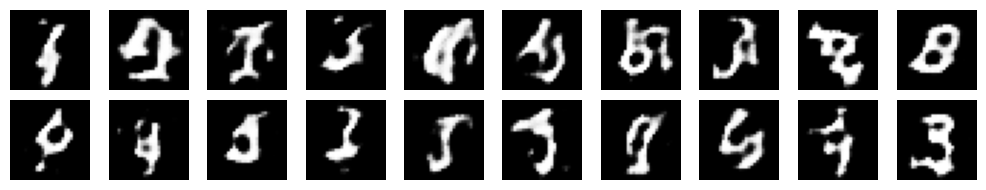

Epoch: 18
Epoch: 18, D_loss: 0.0978860855102539, G_loss: 1.397907018661499


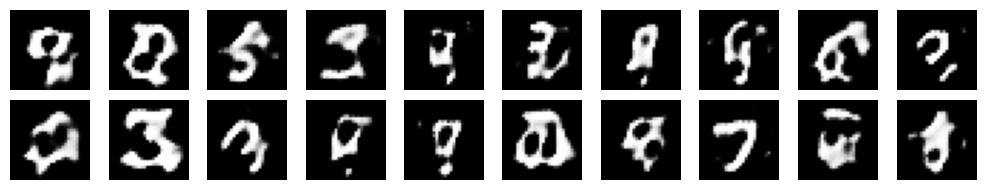

Epoch: 19
Epoch: 19, D_loss: 0.10514974594116211, G_loss: 0.6196928024291992


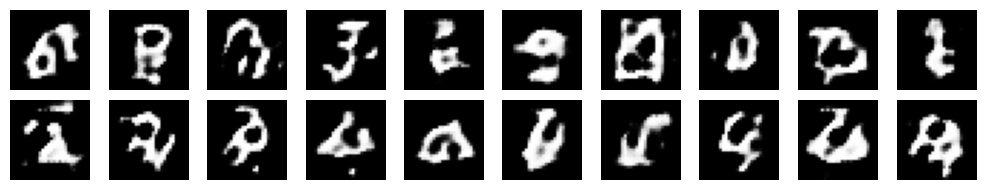

Epoch: 20
Epoch: 20, D_loss: 0.024294011294841766, G_loss: -0.15881505608558655


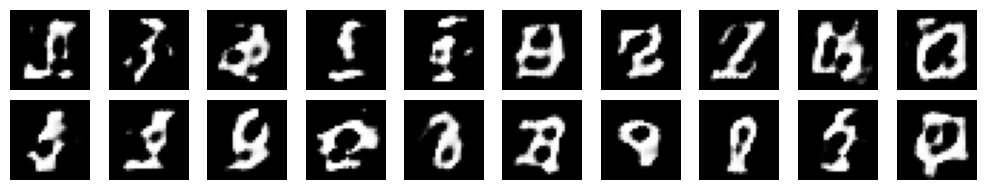

Epoch: 21
Epoch: 21, D_loss: 0.10272717475891113, G_loss: 0.3497757911682129


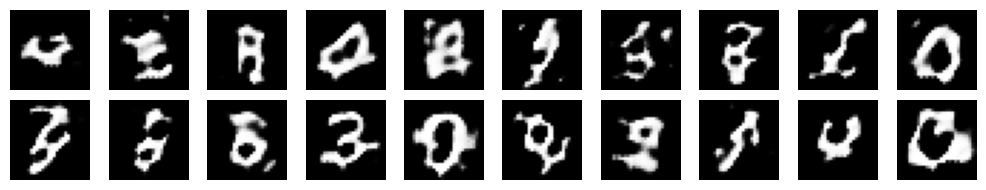

Epoch: 22
Epoch: 22, D_loss: 0.02213883399963379, G_loss: 1.2596068382263184


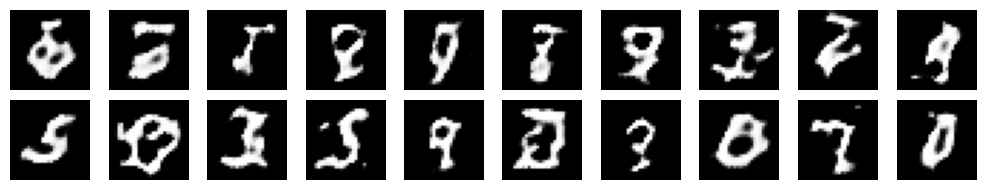

Epoch: 23
Epoch: 23, D_loss: 0.10374265909194946, G_loss: 0.36462366580963135


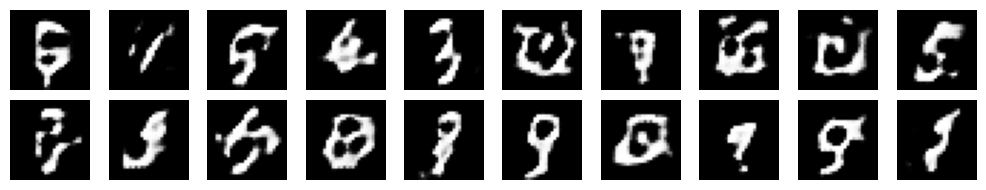

Epoch: 24
Epoch: 24, D_loss: 0.06928163766860962, G_loss: 0.40804657340049744


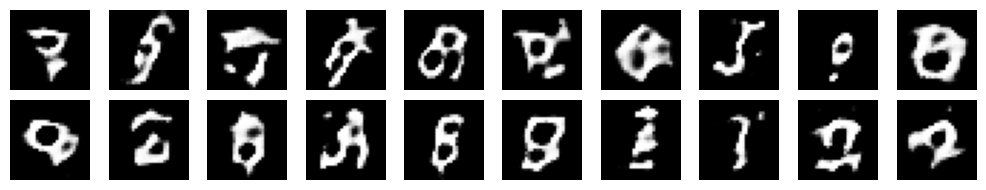

Epoch: 25
Epoch: 25, D_loss: 0.13893771171569824, G_loss: 0.31558290123939514


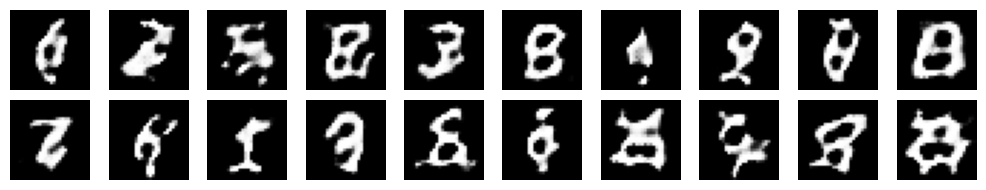

Epoch: 26
Epoch: 26, D_loss: 0.1576446294784546, G_loss: 0.9507571458816528


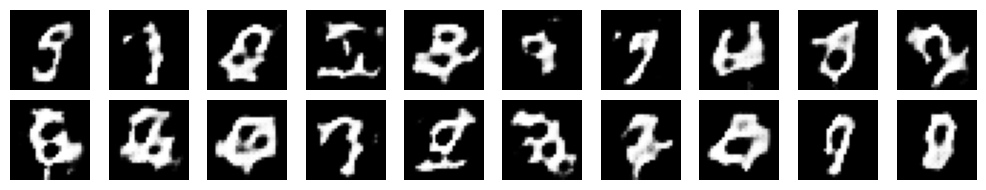

Epoch: 27
Epoch: 27, D_loss: 0.05406314134597778, G_loss: 0.3494279384613037


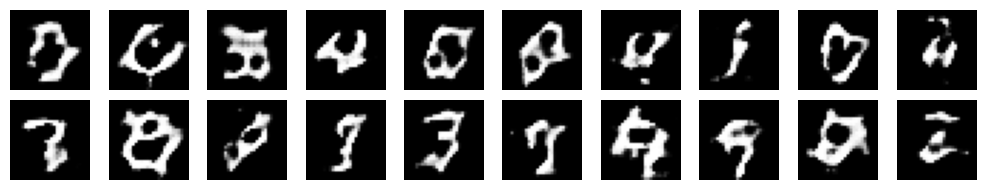

Epoch: 28
Epoch: 28, D_loss: 0.2477121353149414, G_loss: 2.1937854290008545


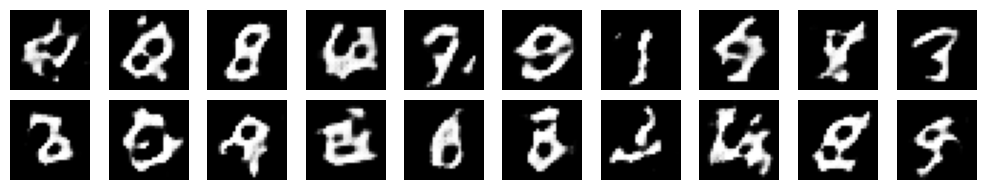

Epoch: 29
Epoch: 29, D_loss: 0.06454324722290039, G_loss: -0.45476019382476807


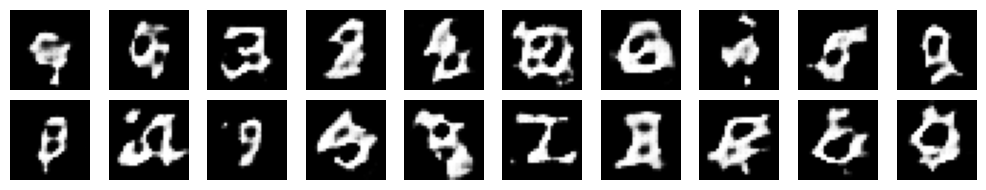

Epoch: 30
Epoch: 30, D_loss: 0.12313008308410645, G_loss: 1.5964713096618652


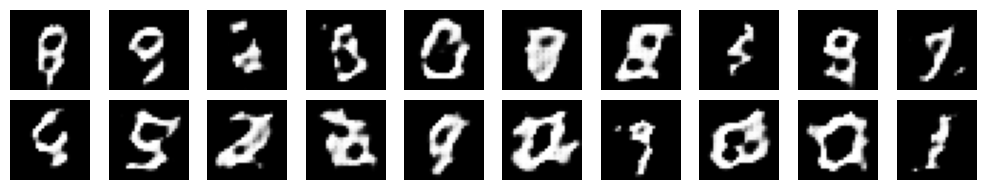

Epoch: 31
Epoch: 31, D_loss: 0.21567273139953613, G_loss: 0.7758829593658447


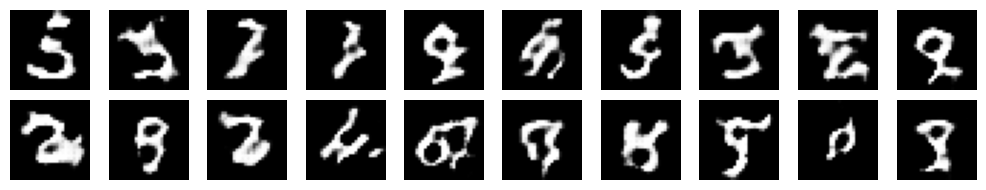

Epoch: 32
Epoch: 32, D_loss: 0.0373380184173584, G_loss: 1.6006234884262085


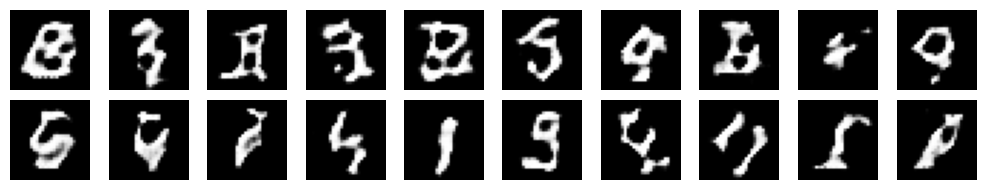

Epoch: 33
Epoch: 33, D_loss: 0.10496079921722412, G_loss: 1.426703691482544


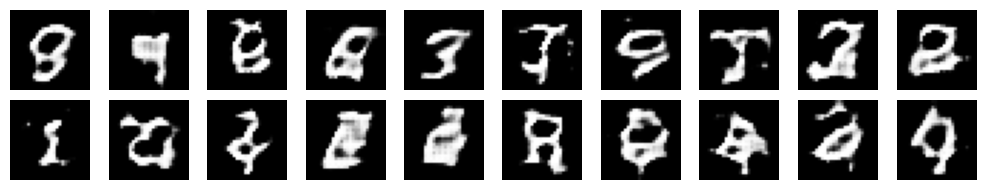

Epoch: 34
Epoch: 34, D_loss: 0.19966793060302734, G_loss: 2.0418004989624023


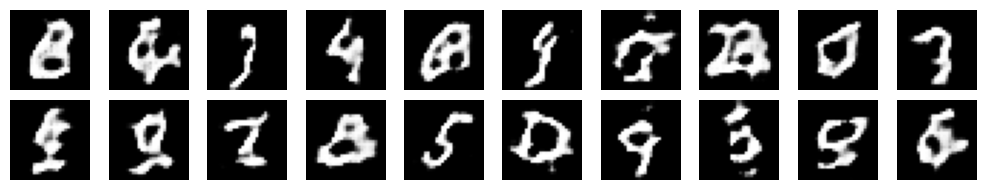

Epoch: 35
Epoch: 35, D_loss: 0.14483022689819336, G_loss: 2.2950141429901123


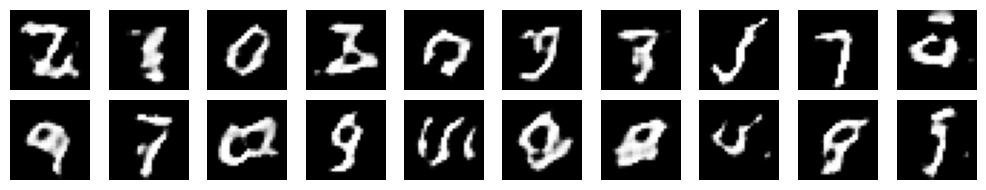

Epoch: 36
Epoch: 36, D_loss: 0.15425729751586914, G_loss: 2.0767083168029785


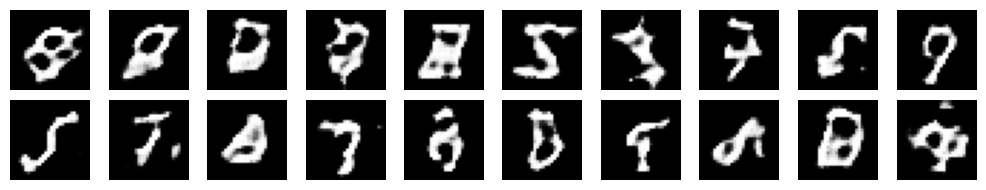

Epoch: 37
Epoch: 37, D_loss: 0.14584779739379883, G_loss: 1.2195767164230347


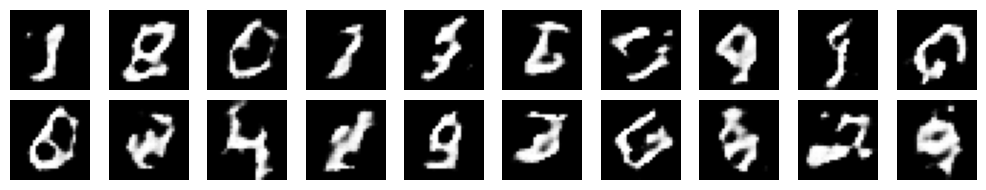

Epoch: 38
Epoch: 38, D_loss: -0.13407230377197266, G_loss: 2.6499667167663574


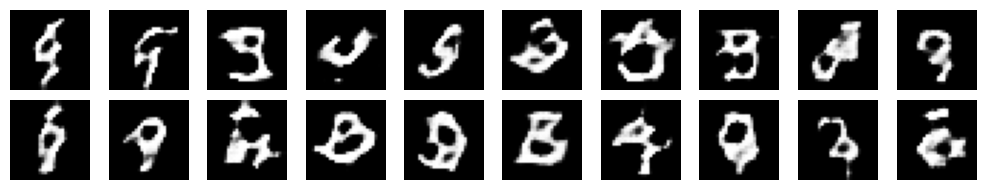

Epoch: 39
Epoch: 39, D_loss: 0.09297060966491699, G_loss: 1.3296594619750977


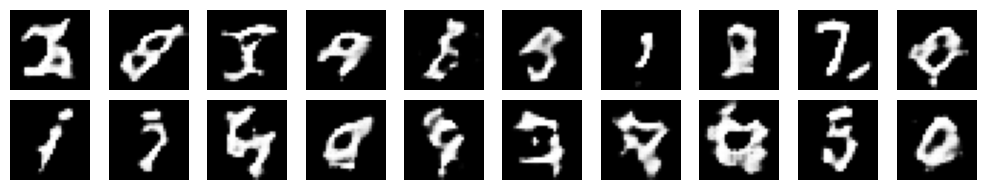

Epoch: 40
Epoch: 40, D_loss: -0.19385719299316406, G_loss: 2.801743984222412


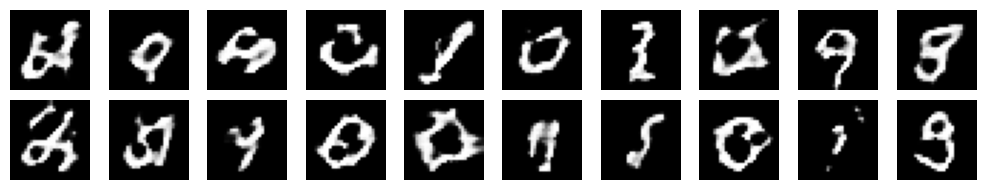

Epoch: 41
Epoch: 41, D_loss: 0.04985971376299858, G_loss: -0.10413479804992676


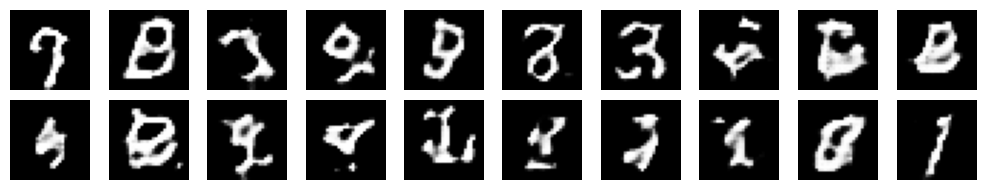

Epoch: 42
Epoch: 42, D_loss: 0.1405085325241089, G_loss: 0.09640372544527054


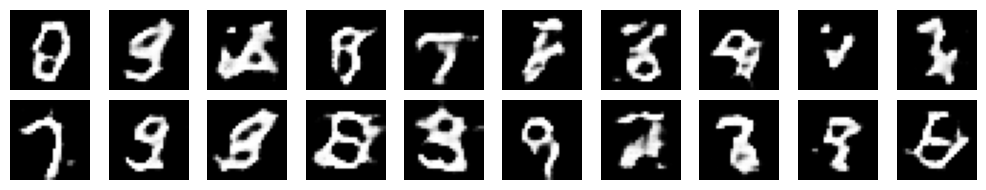

Epoch: 43
Epoch: 43, D_loss: -0.01722121238708496, G_loss: 2.747833251953125


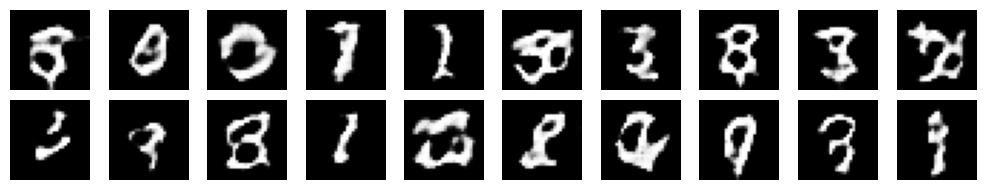

Epoch: 44
Epoch: 44, D_loss: -0.24451637268066406, G_loss: 2.6153693199157715


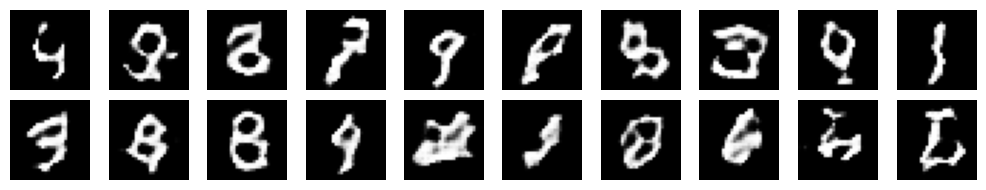

Epoch: 45
Epoch: 45, D_loss: 0.06502717733383179, G_loss: 0.8715453147888184


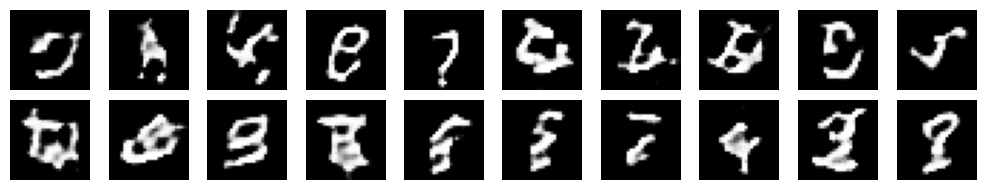

Epoch: 46
Epoch: 46, D_loss: -0.08018064498901367, G_loss: 2.1776788234710693


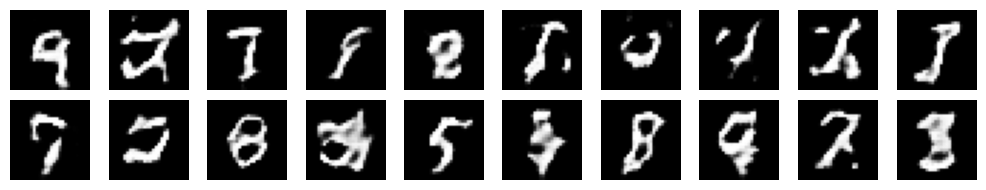

Epoch: 47
Epoch: 47, D_loss: 0.11571592092514038, G_loss: 0.11901942640542984


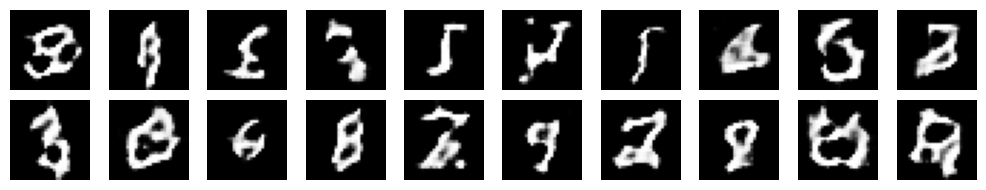

Epoch: 48
Epoch: 48, D_loss: -0.2441883087158203, G_loss: 2.6495354175567627


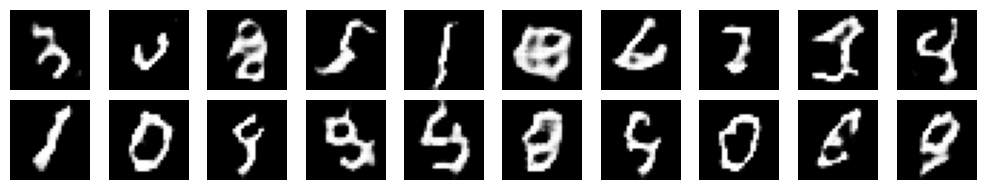

Epoch: 49
Epoch: 49, D_loss: 0.08164871484041214, G_loss: -0.29977208375930786


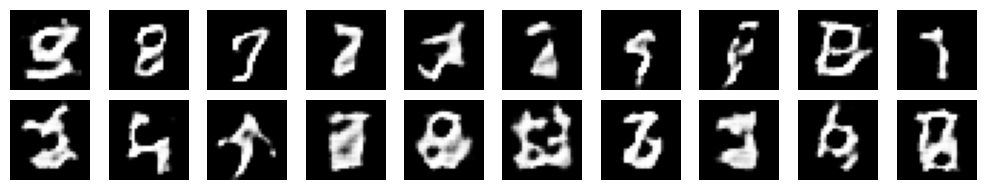

Epoch: 50
Epoch: 50, D_loss: -0.04273509979248047, G_loss: 2.151733875274658


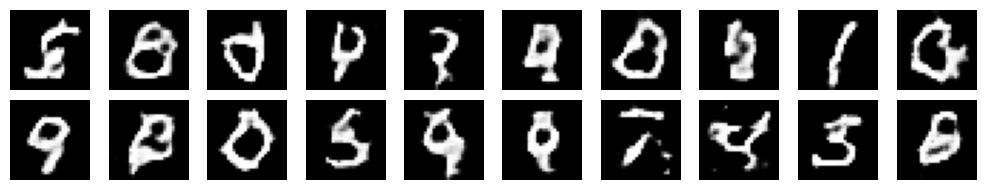

Epoch: 51
Epoch: 51, D_loss: 0.0220797061920166, G_loss: 0.9956351518630981


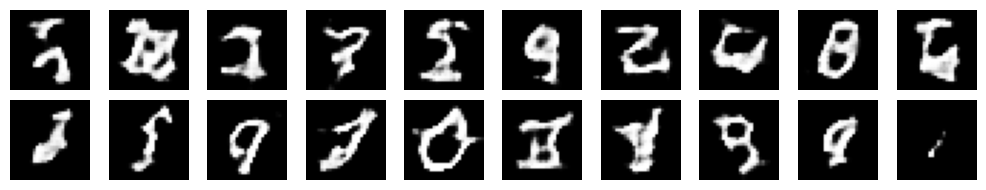

Epoch: 52
Epoch: 52, D_loss: 0.06072167307138443, G_loss: 0.17746734619140625


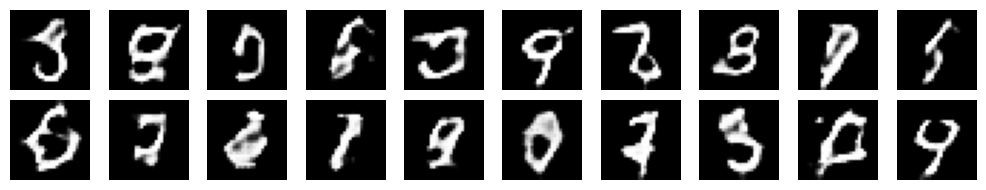

Epoch: 53
Epoch: 53, D_loss: 0.17313647270202637, G_loss: 0.2089102566242218


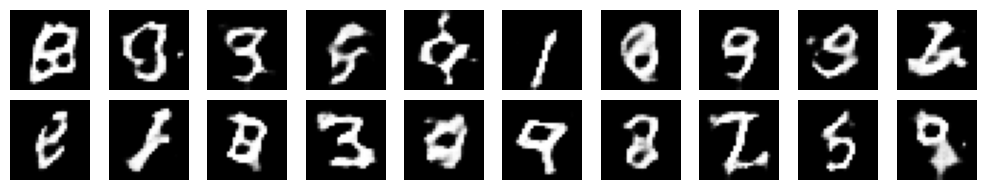

Epoch: 54
Epoch: 54, D_loss: -0.1869339942932129, G_loss: 2.470672130584717


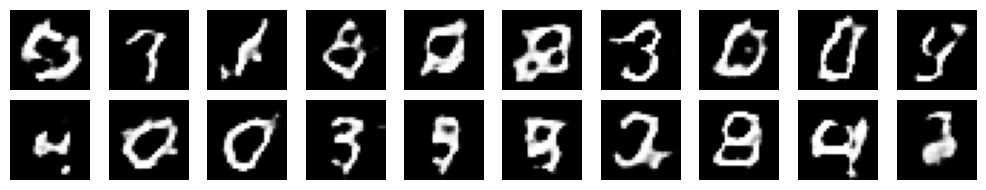

Epoch: 55
Epoch: 55, D_loss: 0.07629668712615967, G_loss: 0.23747244477272034


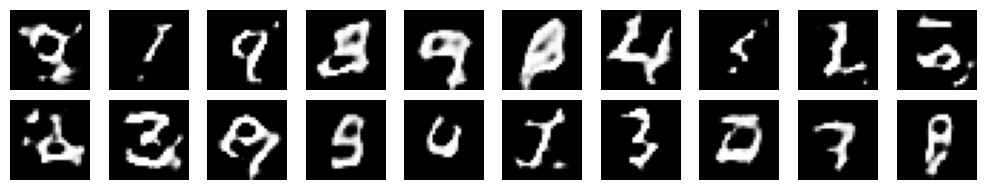

Epoch: 56
Epoch: 56, D_loss: 0.025705575942993164, G_loss: 2.222208023071289


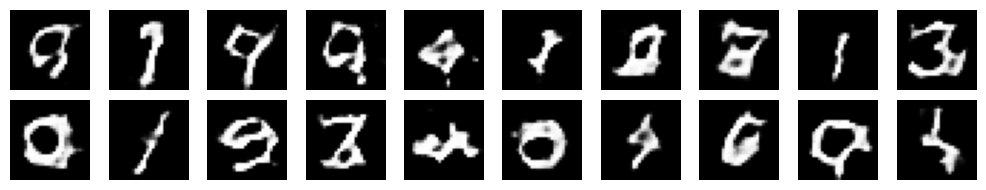

Epoch: 57
Epoch: 57, D_loss: -0.1280500888824463, G_loss: 2.309396743774414


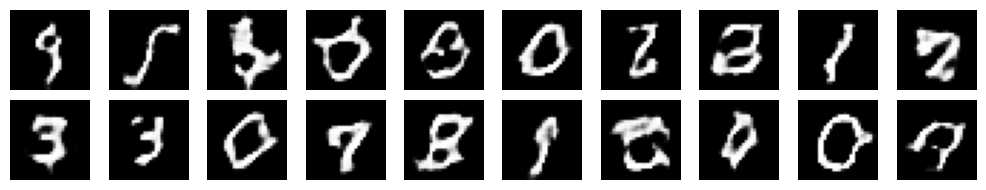

Epoch: 58
Epoch: 58, D_loss: 0.14374637603759766, G_loss: -0.09348097443580627


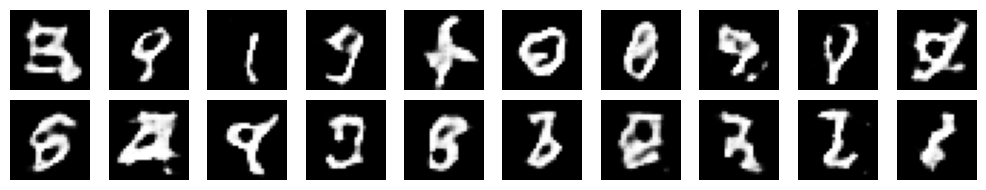

Epoch: 59
Epoch: 59, D_loss: -0.24112343788146973, G_loss: 2.261589765548706


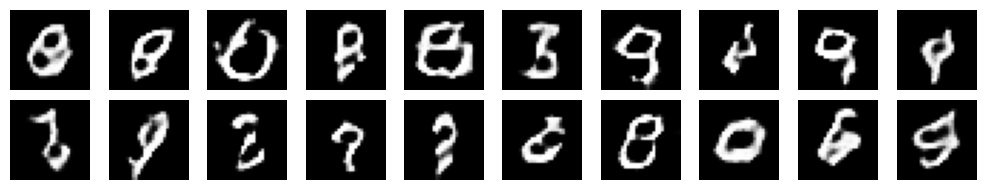

Epoch: 60
Epoch: 60, D_loss: 0.04906439781188965, G_loss: 1.2787401676177979


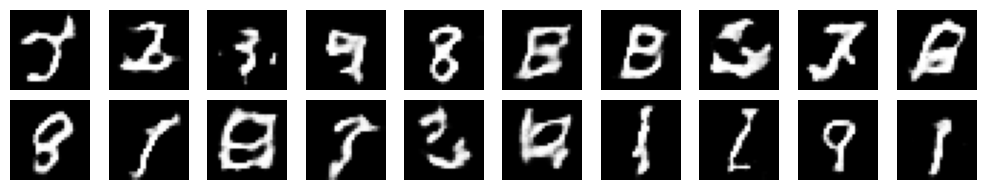

Epoch: 61
Epoch: 61, D_loss: -0.04504752159118652, G_loss: 2.5161798000335693


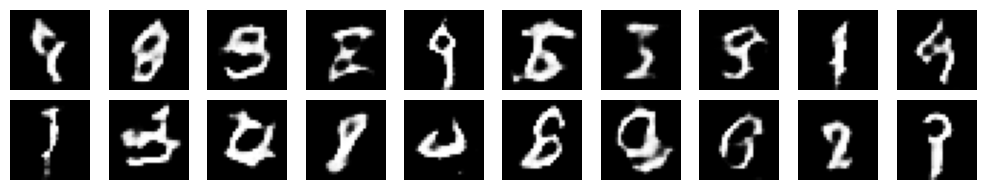

Epoch: 62
Epoch: 62, D_loss: -0.1673365831375122, G_loss: 2.1451497077941895


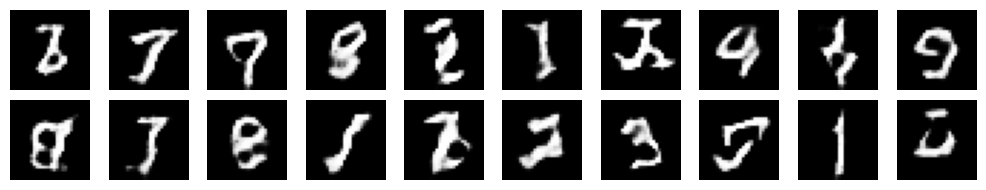

Epoch: 63
Epoch: 63, D_loss: -0.21314573287963867, G_loss: 2.379666805267334


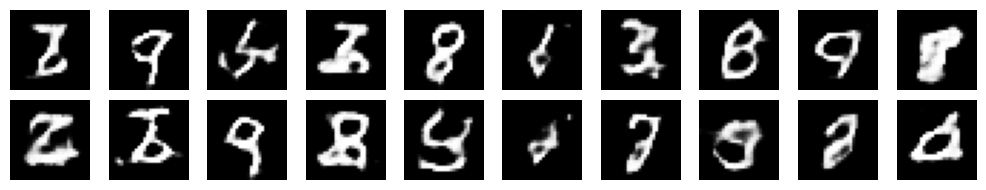

Epoch: 64
Epoch: 64, D_loss: -0.4728672504425049, G_loss: 2.279642105102539


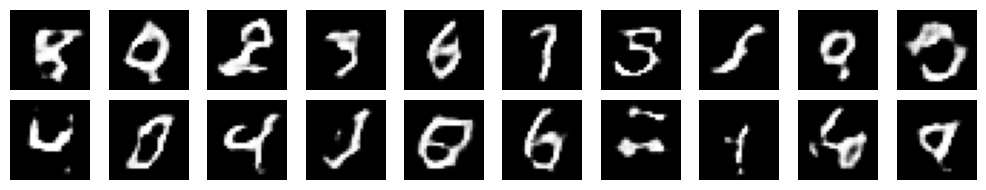

Epoch: 65
Epoch: 65, D_loss: 0.1352769136428833, G_loss: 1.5438785552978516


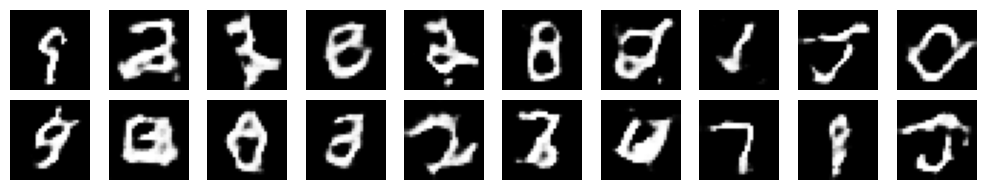

Epoch: 66
Epoch: 66, D_loss: 0.20479846000671387, G_loss: 0.08924314379692078


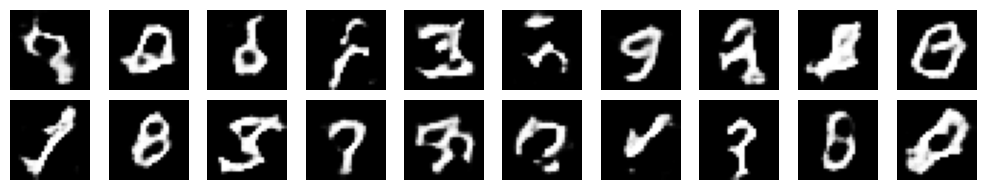

Epoch: 67
Epoch: 67, D_loss: 0.1388261318206787, G_loss: 2.084803819656372


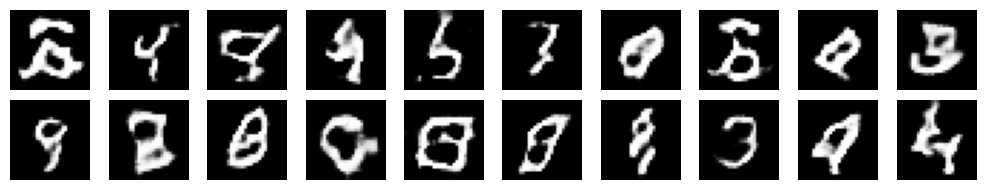

Epoch: 68
Epoch: 68, D_loss: 0.06262421607971191, G_loss: 0.5871503353118896


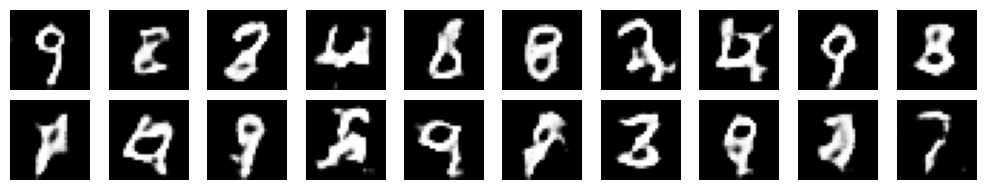

Epoch: 69
Epoch: 69, D_loss: -0.25020885467529297, G_loss: 1.7504875659942627


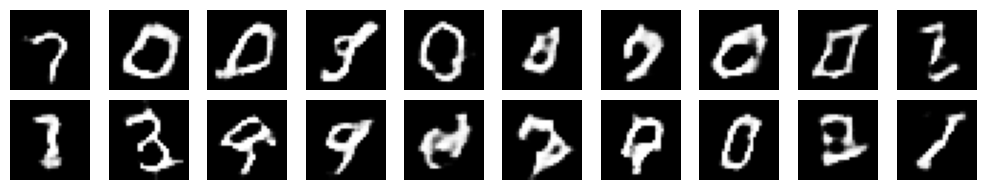

Epoch: 70
Epoch: 70, D_loss: -0.39958250522613525, G_loss: 2.481581926345825


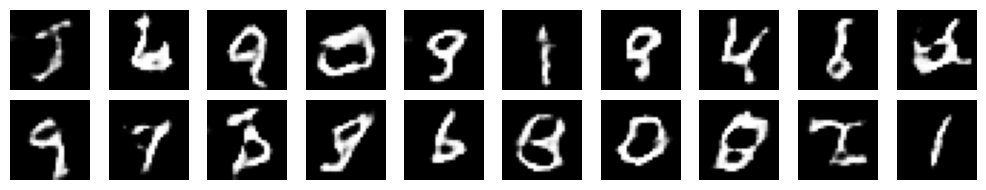

Epoch: 71
Epoch: 71, D_loss: -0.3175455331802368, G_loss: 2.1499013900756836


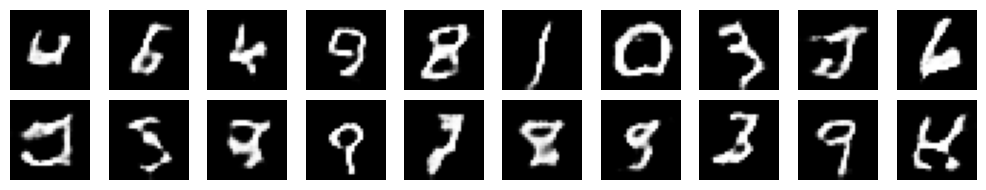

Epoch: 72
Epoch: 72, D_loss: 0.13339293003082275, G_loss: 1.7944929599761963


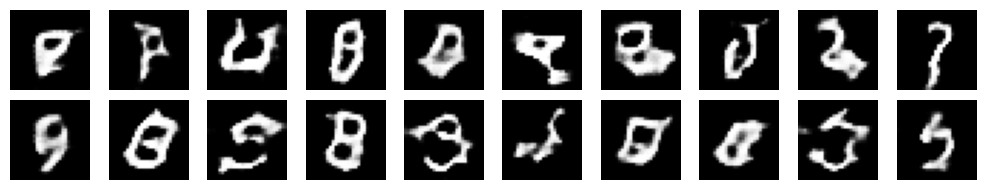

Epoch: 73
Epoch: 73, D_loss: 0.03757834434509277, G_loss: 1.5902118682861328


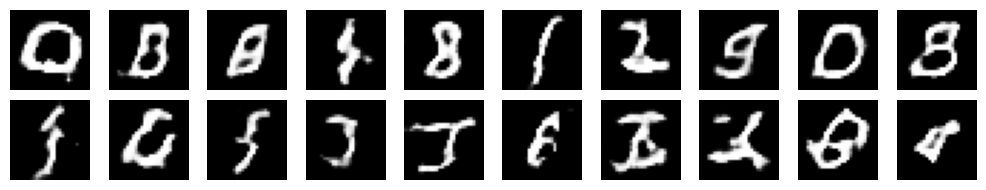

Epoch: 74
Epoch: 74, D_loss: -0.16346526145935059, G_loss: 2.0956735610961914


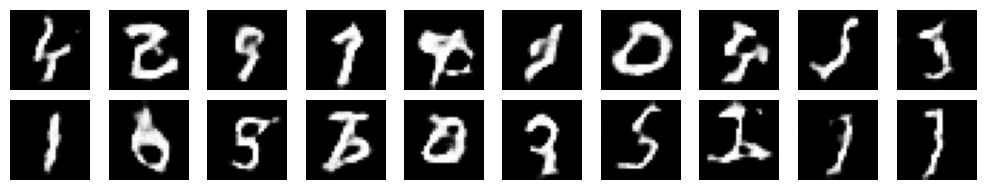

Epoch: 75
Epoch: 75, D_loss: -0.17780828475952148, G_loss: 2.468869209289551


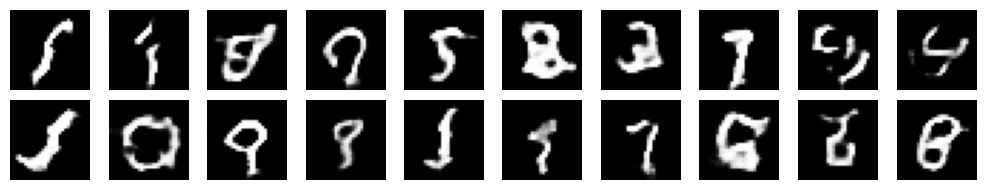

Epoch: 76
Epoch: 76, D_loss: 0.10863935947418213, G_loss: 1.3519606590270996


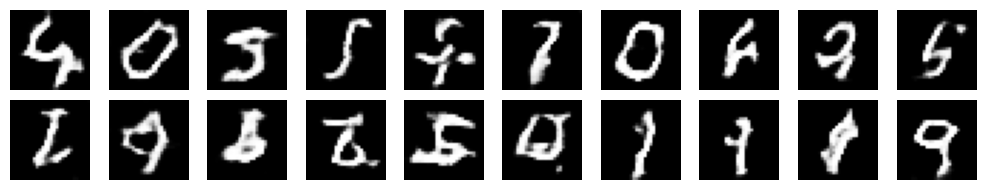

Epoch: 77
Epoch: 77, D_loss: -0.3123128414154053, G_loss: 2.321596145629883


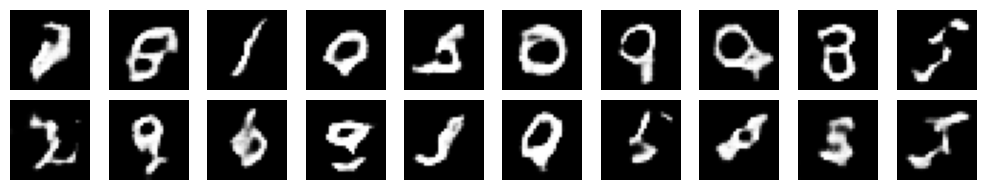

Epoch: 78
Epoch: 78, D_loss: -0.08766090869903564, G_loss: 2.005753517150879


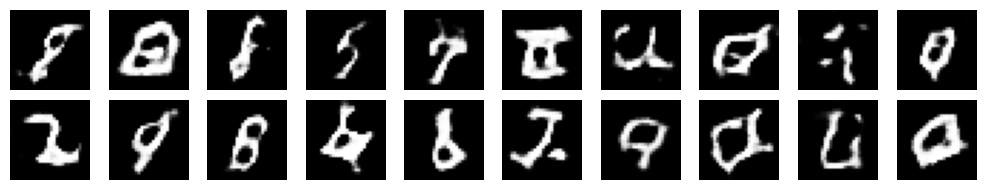

Epoch: 79
Epoch: 79, D_loss: -0.0170896053314209, G_loss: 0.8358827829360962


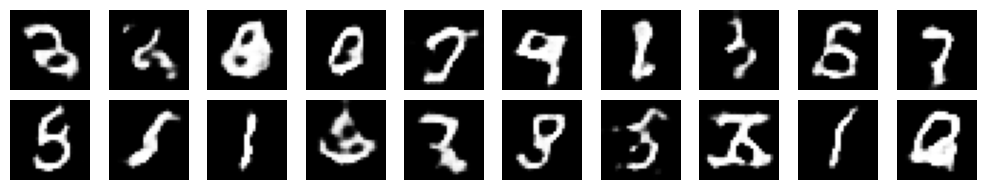

Epoch: 80
Epoch: 80, D_loss: 0.04239392280578613, G_loss: 1.7173888683319092


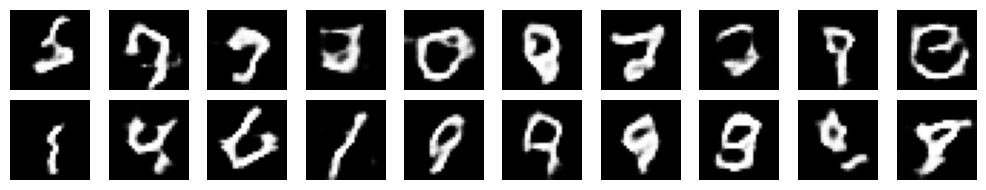

Epoch: 81
Epoch: 81, D_loss: -0.3394622802734375, G_loss: 2.1374170780181885


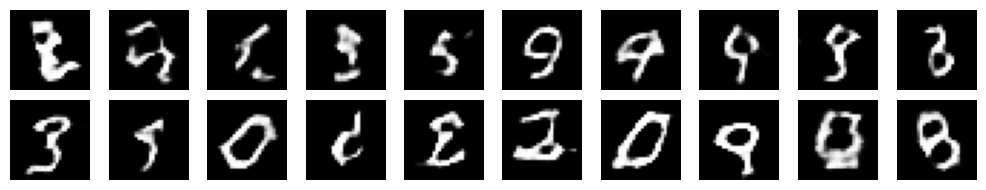

Epoch: 82
Epoch: 82, D_loss: 0.00681304931640625, G_loss: 1.6969544887542725


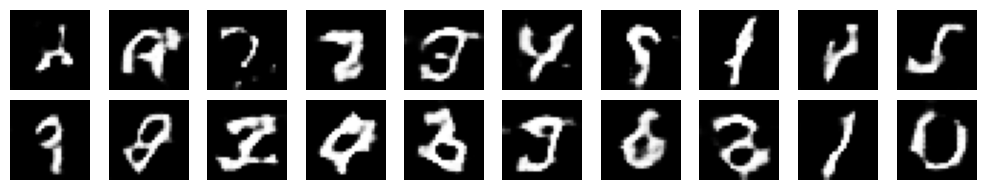

Epoch: 83
Epoch: 83, D_loss: 0.051823168992996216, G_loss: 0.026567896828055382


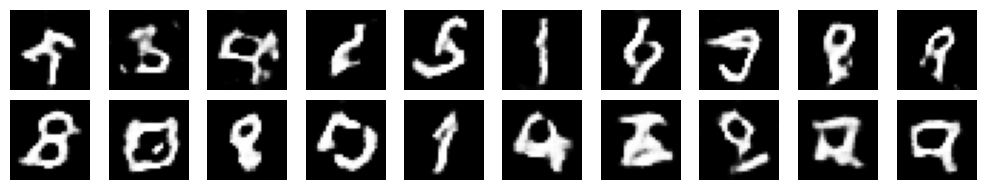

Epoch: 84
Epoch: 84, D_loss: -0.140072762966156, G_loss: 1.0382633209228516


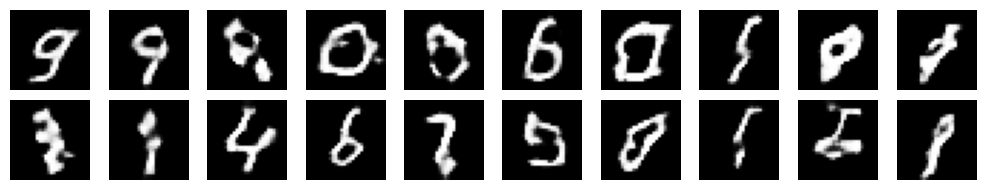

Epoch: 85
Epoch: 85, D_loss: -0.31242382526397705, G_loss: 1.8874926567077637


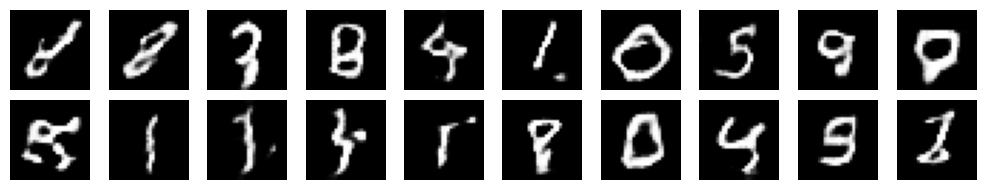

Epoch: 86


In [ ]:

@tf.function
def train_step(real_images):
    batch_size = tf.shape(real_images)[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, LATENT_DIM))

    # Train Discriminator
    for _ in range(N_CRITIC):
        with tf.GradientTape() as tape:
            fake_images = generator(random_latent_vectors)
            real_logits = discriminator(real_images)
            fake_logits = discriminator(fake_images)
            d_loss = tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits)

        grads = tape.gradient(d_loss, discriminator.trainable_weights)
        d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

        # Weight clipping for discriminator
        for w in discriminator.trainable_weights:
            w.assign(tf.clip_by_value(w, -CLIP_VALUE, CLIP_VALUE))

    # Train Generator
    random_latent_vectors = tf.random.normal(shape=(batch_size, LATENT_DIM))
    with tf.GradientTape() as tape:
        fake_images = generator(random_latent_vectors)
        fake_logits = discriminator(fake_images)
        g_loss = -tf.reduce_mean(fake_logits)

    grads = tape.gradient(g_loss, generator.trainable_weights)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))

    return d_loss, g_loss

# Training loop
def train(dataset, epochs, batch_size):
    for epoch in range(epochs):
        print(f'Epoch: {epoch}')
        for i in range(int(dataset.shape[0] / batch_size)):
            real_images = dataset[i * batch_size:(i + 1) * batch_size]
            d_loss, g_loss = train_step(real_images)
        print(f'Epoch: {epoch}, D_loss: {d_loss.numpy()}, G_loss: {g_loss.numpy()}')
        display_generated_images(epoch)

# Start training
train(X_train, EPOCHS, BATCH_SIZE)

In [ ]:
display_generated_images(10)